# Задача

В данной работе решается задача классификации текстов с использованием таких методов, как: 
1. SVM
2. Дерево решений
3. Бэггинг
4. Случайный лес
5. Градиентный бустинг
6. Наивный байес
7. Голосование

Также выполнена предобработка текстов для обучения (очистка от стоп-слов, балансировка, стэмминг, преобразование в tf-idf матрицу).

# Загрузка библиотек и данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

from nltk import ngrams, FreqDist # для подсчёта частот слов 
from wordcloud import WordCloud   # для рисования облака слов

from sklearn.feature_extraction.text import CountVectorizer # для простого подсчёта числа слов
from sklearn.feature_extraction.text import TfidfVectorizer # для TF-IDF

from sklearn.svm import SVC # модель на основе метода опорных векторов ( Support Vector Machine )

import nltk 
from nltk.corpus import stopwords # для работы со стоп-словами (шумовыми словами): прелогами, частицами, междометьями
from nltk.stem import PorterStemmer, SnowballStemmer # стеммеры, для приведения слов к их основе, уменьшает число слов
from nltk.tokenize import word_tokenize # разбивает тексты на слова

In [ ]:
url = 'https://raw.githubusercontent.com/LevasyukDY/ML/main/datasets/news.csv'
# данные -- новости, классифицируемые по трем источникам
data = pd.read_csv(url)
data

,Unnamed: 0,news,source
0,0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,2,Практически во всех странах мира введены огра...,0.0
3,3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,4,Совет директоров «Почты России» проголосовал ...,2.0
...,...,...,...
19457,19457,С 17 декабря в России блокируется один из кру...,NaN
19458,19458,Первые упоминания разработки тёмной темы в Go...,NaN
19459,19459,Компания Oppo презентовала два новых продукта...,NaN
19460,19460,"Основой презентации стала Windows 10, которая...",NaN


# Подготовка данных

## Очистка данных

Очевидно, что в столбце 'Unnamed: 0' хранятся индексы новостей, нам этот столбец ни к чему, удаляем его

In [ ]:
cleared_data = data.drop(columns='Unnamed: 0')
cleared_data

,news,source
0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,Практически во всех странах мира введены огра...,0.0
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,Совет директоров «Почты России» проголосовал ...,2.0
...,...,...
19457,С 17 декабря в России блокируется один из кру...,NaN
19458,Первые упоминания разработки тёмной темы в Go...,NaN
19459,Компания Oppo презентовала два новых продукта...,NaN
19460,"Основой презентации стала Windows 10, которая...",NaN


In [ ]:
cleared_data['source'].unique()

array([ 1.,  0.,  2., nan])

In [ ]:
cleared_data.isna().sum(axis=0)

news         0
source    1102
dtype: int64

Видим, что в столбце 'source' помимо трёх источников есть пропуски. Отделим строки с этими пропусками в отдельный датафрейм, потом предскажем источник на них ради интереса.

In [ ]:
nan_data = cleared_data[ cleared_data['source'].isnull() ]
nan_data

,news,source
18360,Глава форума Reddit Стив Хаффман раскритикова...,NaN
18361,Французское архитектурное бюро Vincent Calleb...,NaN
18362,"Samsung провела мероприятие Galaxy Unpacked, ...",NaN
18363,В бета-версии клиента Telegram для Android с ...,NaN
18364,Журналистам из XDA удалось раздобыть минималь...,NaN
...,...,...
19457,С 17 декабря в России блокируется один из кру...,NaN
19458,Первые упоминания разработки тёмной темы в Go...,NaN
19459,Компания Oppo презентовала два новых продукта...,NaN
19460,"Основой презентации стала Windows 10, которая...",NaN


Удалим пропуски из очищенных данных

In [ ]:
cleared_data = cleared_data.dropna()
cleared_data

,news,source
0,Официальный аккаунт PlayStation опубликовал т...,1.0
1,Китайская компания Mobvoi опубликовала на офи...,1.0
2,Практически во всех странах мира введены огра...,0.0
3,"Депутат Госдумы, единоросс Антон Горелкин вне...",2.0
4,Совет директоров «Почты России» проголосовал ...,2.0
...,...,...
18355,С 17 декабря в России блокируется один из кру...,1.0
18356,Первые упоминания разработки тёмной темы в Go...,1.0
18357,Компания Oppo презентовала два новых продукта...,1.0
18358,"Основой презентации стала Windows 10, которая...",0.0


<Axes: xlabel='count', ylabel='source'>

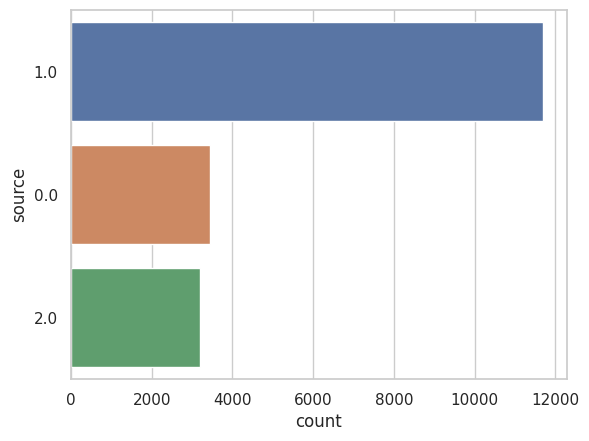

In [ ]:
seaborn.set_theme(style="whitegrid")
seaborn.countplot( data=cleared_data, y='source', order=cleared_data['source'].unique() )

Видим, что новостей по первому источнику у нас больше примерно раза в 3-4. 

Хорошо бы произвести балансировку.

## Балансировка

При использовании алгоритма машинного обучения очень важно обучить модель на наборе данных с почти таким же количеством выборок. Это называется сбалансированным классом.

Нам нужны сбалансированные классы для обучения модели, но, если классы не сбалансированы, нам нужно использовать метод балансировки классов перед использованием алгоритма машинного обучения.

In [ ]:
data_zero = cleared_data[ cleared_data['source'] == 0 ]
data_one = cleared_data[ cleared_data['source'] == 1 ]
data_two = cleared_data[ cleared_data['source'] == 2 ]

data_one = data_one.sample(3500, random_state=42) # берём 3500 записей из единиц
balanced_data = pd.concat([data_zero, data_one, data_two]) # объединение записей
balanced_data = balanced_data.sample(frac=1, random_state=42) # перемешивание данных
balanced_data

,news,source
16366,Компания Google представила новый игровой обл...,0.0
7454,«Вымпелком» в I квартале 2015 г. заработал 6...,2.0
16499,Сотрудники Huawei Technologies Co работали на...,0.0
11839,Представители интересов мессенджера Telegram ...,0.0
620,«Рокетбанк» всё. Компания-владелец Qiwi сообщ...,1.0
...,...,...
17184,На мероприятии в Китае компания Oppo представ...,1.0
523,Компания Xiaomi выпустила в продажу мышь Xiao...,1.0
4240,Американское издание The Wall Street Journal ...,1.0
4509,В этом году индустрия видеоигр обрела второе ...,0.0


## Стэмминг

Стэмминг – это процесс нахождения основы слова для заданного исходного слова. Основа слова не обязательно совпадает с морфологическим корнем слова.

In [ ]:
# загрузка модуля стоп-слов - слов, которые не имеют большой значимости: и, или, только, ...
nltk.download('stopwords') # стоп-слова
nltk.download('punkt') # пунктуация

stemmer = SnowballStemmer('russian', ignore_stopwords=True)
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Будем приводить все слова к одному основанию, избавляясь от окончаний и предлогов.

Основание не тоже самое что и корень, но иногда совпадают.

In [ ]:
print('Некоторые из стоп-слов:', stop_words[:10])

Некоторые из стоп-слов: ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']


In [ ]:
balanced_data['news'][42] # посмотрим исходный вид одной новости

' Музыканты Стас Намин и Василий Вакуленко (Баста), а также продюсер и композитор Виктор Дробыш объявили на конференции в Госдуме, что изымают свои произведения из управления РАО.  Эта организация по решению правительства собирает вознаграждение в пользу авторов с радиостанций, телеканалов, организаторов концертов и т. д. В 2014 г. сборы составили 4,6 млрд руб.  Музыканты недовольны, как РАО собирает и выплачивает авторские отчисления, в том числе те, которые собираются при проведении концертов. Намин рассказал, что ничего не получает от РАО, хотя является автором популярных песен, которые много лет исполняются на концертах и звучат на радиостанциях. Вакуленко говорит, что дает не меньше сотни концертов в год, при этом получает от РАО всего 70 000–80 000 руб. в год. Намин не исключает, что передаст свои права в управление другой организации, но какой именно – пока не раскрывает.  Из-под управления РАО свои права также забрали певица Нюша, певцы Иван Дорн, Вячеслав Бутусов, Константин М

In [ ]:
def stem_text(text):
  words = word_tokenize(text.lower())         # разделит текст на слова
  # my_stop_words = ['который', 'которые', 'которая', 'кроме', 'однако', 'также', 
  #                  'как', 'так', 'подобно', 'подобный', 'подобная', 'подобные', 
  #                  'является', 'являются', 'должна', 'должны', 'должен', 
  #                  'должно', 'это', 'эти', 'своё', 'свои', 'своя', 'говорил', 
  #                  'говорила', 'говорили', 'говорят', 'говорит', 'возможно', 
  #                  'возможны', 'возможна', 'получать', 'получили', 'получатель',
  #                  'получить', 'получатель', 'получатели', 'новый', 'новая', 
  #                  'новые', 'имеет', 'те', 'ещё', 'одни', 'вместе', 'частая',
  #                  'первый', 'первые', 'первая', 'первое', 'будут', 'будет',
  #                  'одно', 'просто', 'просты', 'проста', 'простая', 'простой', 
  #                  'другой', 'другие', 'другая', 'другое', 'создал', 'создали',
  #                  'создаёт', 'создаст', 'создала', 'работа', 'со', 'заявил', 
  #                  'заявила', 'заявили', 'сам', 'часто', 'частый', 'частые' ]
  stemed_words = [  stemmer.stem(word)          # возвращает основу слова
                    for word in words           # проходим по каждому слову в тексте
                    if word.isalpha() and
                    word not in stop_words ]    # игнорируем слова из списка стоп-слов
                    # word not in my_stop_words ]
                    # word.isalnum() - игнорируем символы
                    # word.isalpha() - игнорируем числа и символы

  unique_stemed_words = list(dict.fromkeys(stemed_words)) # удалим дубликаты
  return " ".join(unique_stemed_words) # возвращаем в виде строки

stem_text(balanced_data['news'][42]) # проверяем функцию

'музыкант стас намин васил вакуленк баст такж продюсер композитор виктор дробыш объяв конференц госдум изыма сво произведен управлен ра эт организац решен правительств собира вознагражден польз автор радиостанц телеканал организатор концерт сбор состав млрд руб недовольн выплачива авторск отчислен числ те котор проведен рассказа получа хот явля популярн пес лет исполня звучат говор дает меньш сотн год исключа передаст прав имен пок раскрыва забра певиц нюш певц ива дорн вячесла бутус константин меладз доминик джокер александр бреславск павел есенин эраст чантур ведом источник музыкальн рынк подтверд представител перв издательств пми управля договор сказа обвиня удобн сам контролирова скольк прода билет обрат обществ просьб изъят репертуар некотор заявлен добав директор продюсерск центр игор матвиенк андр лукин счита либ продума продиктова финансов причин одн сторон артист прощ работа полн сумм участ посредник вид рассужда внос хаос рынок полност как образ будут медиакомпан должн раздел

Применим эту функцию ко всем новостям

In [ ]:
%%time
stemmed_news = balanced_data['news'].apply(stem_text)
stemmed_news

CPU times: user 3min 14s, sys: 421 ms, total: 3min 14s
Wall time: 3min 29s


16366    компан google представ нов игров облачн сервис...
7454     i квартал заработа млрд руб выручк практическ ...
16499    сотрудник huawei technologies co работа миниму...
11839    представител интерес мессенджер telegram напра...
620      рокетбанк все qiwi сообщ смогл найт покупател ...
                               ...                        
17184    мероприят кита компан oppo представ беспроводн...
523      компан xiaomi выпуст продаж мыш xiaoai smart m...
4240     американск издан the wall street journal проан...
4509     год индустр видеоигр обрел втор дыхан благодар...
1774     rambler group александр мамут меня сист управл...
Name: news, Length: 10162, dtype: object

Запишем обработанный текст и количество слов в тексте в новые столбцы.

In [ ]:
balanced_data['stemmed_news'] = stemmed_news
balanced_data['words_count'] = balanced_data['stemmed_news'].apply(lambda s: s.count(' ') + 1)
balanced_data

,news,source,stemmed_news,words_count
16366,Компания Google представила новый игровой обл...,0.0,компан google представ нов игров облачн сервис...,263
7454,«Вымпелком» в I квартале 2015 г. заработал 6...,2.0,i квартал заработа млрд руб выручк практическ ...,227
16499,Сотрудники Huawei Technologies Co работали на...,0.0,сотрудник huawei technologies co работа миниму...,264
11839,Представители интересов мессенджера Telegram ...,0.0,представител интерес мессенджер telegram напра...,237
620,«Рокетбанк» всё. Компания-владелец Qiwi сообщ...,1.0,рокетбанк все qiwi сообщ смогл найт покупател ...,116
...,...,...,...,...
17184,На мероприятии в Китае компания Oppo представ...,1.0,мероприят кита компан oppo представ беспроводн...,85
523,Компания Xiaomi выпустила в продажу мышь Xiao...,1.0,компан xiaomi выпуст продаж мыш xiaoai smart m...,74
4240,Американское издание The Wall Street Journal ...,1.0,американск издан the wall street journal проан...,57
4509,В этом году индустрия видеоигр обрела второе ...,0.0,год индустр видеоигр обрел втор дыхан благодар...,389


# Анализ текстов

<Axes: xlabel='words_count', ylabel='Count'>

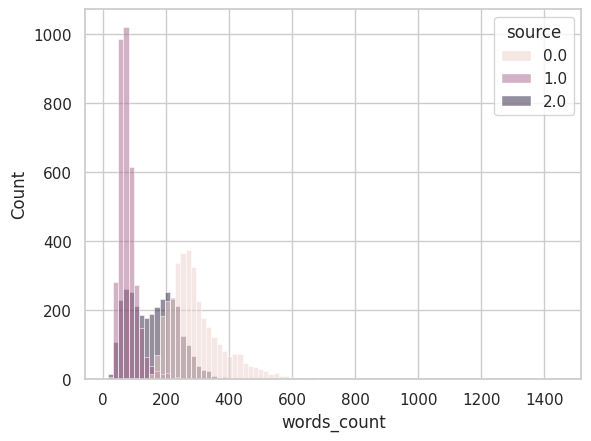

In [ ]:
seaborn.histplot( data=balanced_data, x='words_count', hue='source' )

In [ ]:
gazeta_news = balanced_data[balanced_data['source'] == 0]['stemmed_news'].values
rozetked_news = balanced_data[balanced_data['source'] == 1]['stemmed_news'].values
vedomosti_news = balanced_data[balanced_data['source'] == 2]['stemmed_news'].values

text_gazeta =  ". ".join(gazeta_news)
text_rozetked =  ". ".join(rozetked_news)
text_vedomosti =  ". ".join(vedomosti_news)

In [ ]:
def get_top_words(texts, N, min_df = 10):
    counter = CountVectorizer(min_df=min_df)             
    wf = counter.fit_transform( texts )
    vocabulary = list(counter.vocabulary_.items())
    vocabulary.sort(key = lambda x: x[1])
    vocabulary = np.array( list(map(lambda x: x[0], vocabulary) ))
    return vocabulary[ np.array(wf.sum(axis=0)).flatten().argsort()[:N] ]

In [ ]:
print('Топ слов из gazeta.ru')
print( get_top_words(gazeta_news, 20) )

print()
print('Топ слов из rozetked.ru')
print( get_top_words(rozetked_news, 20) )

print()
print('Топ слов из vedomosti.ru')
print( get_top_words(vedomosti_news, 20) )

Топ слов из gazeta.ru
['лестниц' 'преодолел' 'изготовл' 'lost' 'спасательн' 'пресеч'
 'коррупцион' 'lollipop' 'whole' 'magsafe' 'бессмерт' 'комед' 'наруж'
 'west' 'сортировк' 'корронс' 'liveinternet' 'специализац'
 'специализирующ' 'la']

Топ слов из rozetked.ru
['долгожда' 'оттенк' 'творчеств' 'бог' 'тачпад' 'hisilicon' 'ощущен'
 'павл' 'париж' 'та' 'сюрприз' 'пережива' 'перезагруз' 'перемен' 'беспоко'
 'ступен' 'перечн' 'стресс' 'подсчет' 'подсистем']

Топ слов из vedomosti.ru
['приостанавлива' 'суханов' 'мегабайт' 'счел' 'мацоцк' 'материальн'
 'матер' 'nyt' 'побужда' 'таксофон' 'марок' 'маринич' 'мам' 'тарифицирова'
 'татарстан' 'малах' 'макар' 'повыш' 'супермаркет' 'nbc']


In [ ]:
def plot_word_cloud(text: str, title: str):
    wordcloud = WordCloud( width = 800, height = 600).generate(text)
    plt.figure(figsize = (15, 10))
    plt.title(title)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

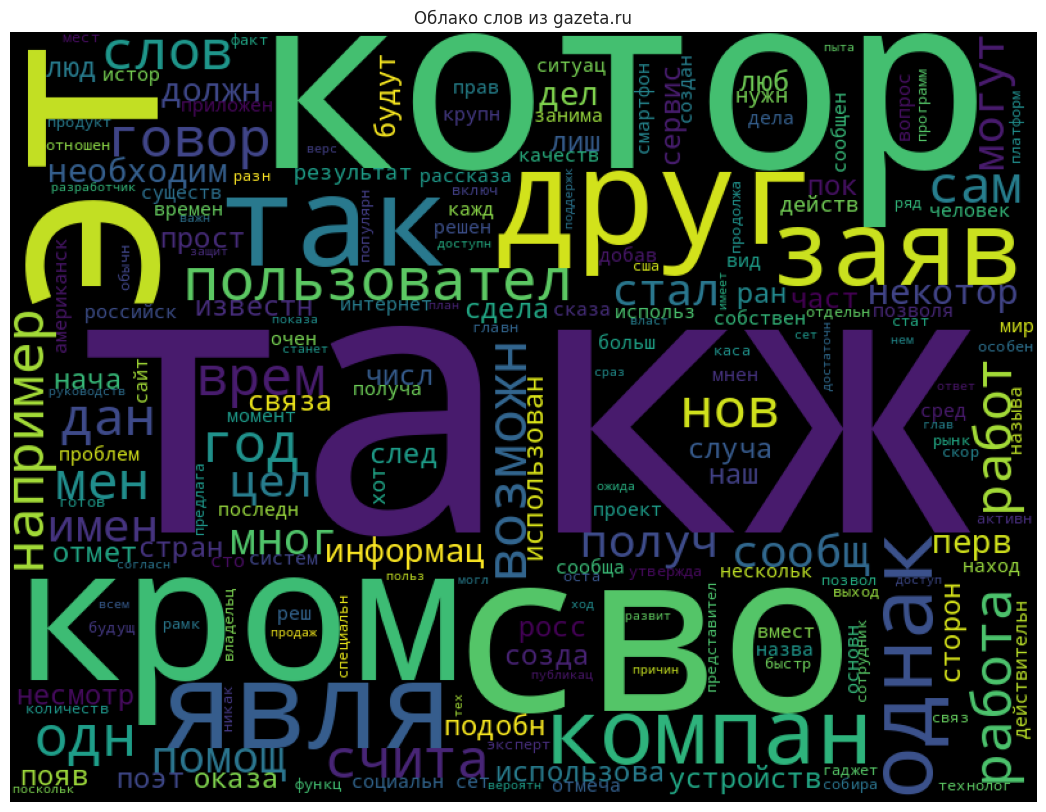

In [ ]:
plot_word_cloud(text_gazeta, 'Облако слов из gazeta.ru')

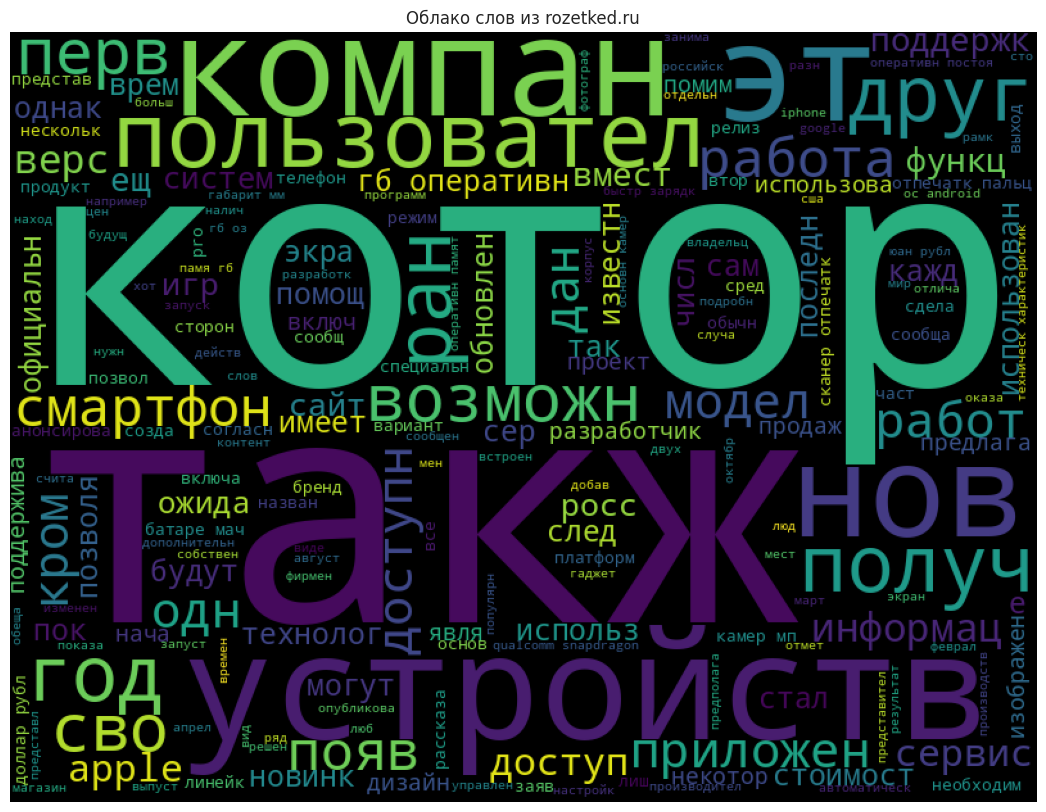

In [ ]:
plot_word_cloud(text_rozetked, 'Облако слов из rozetked.ru')

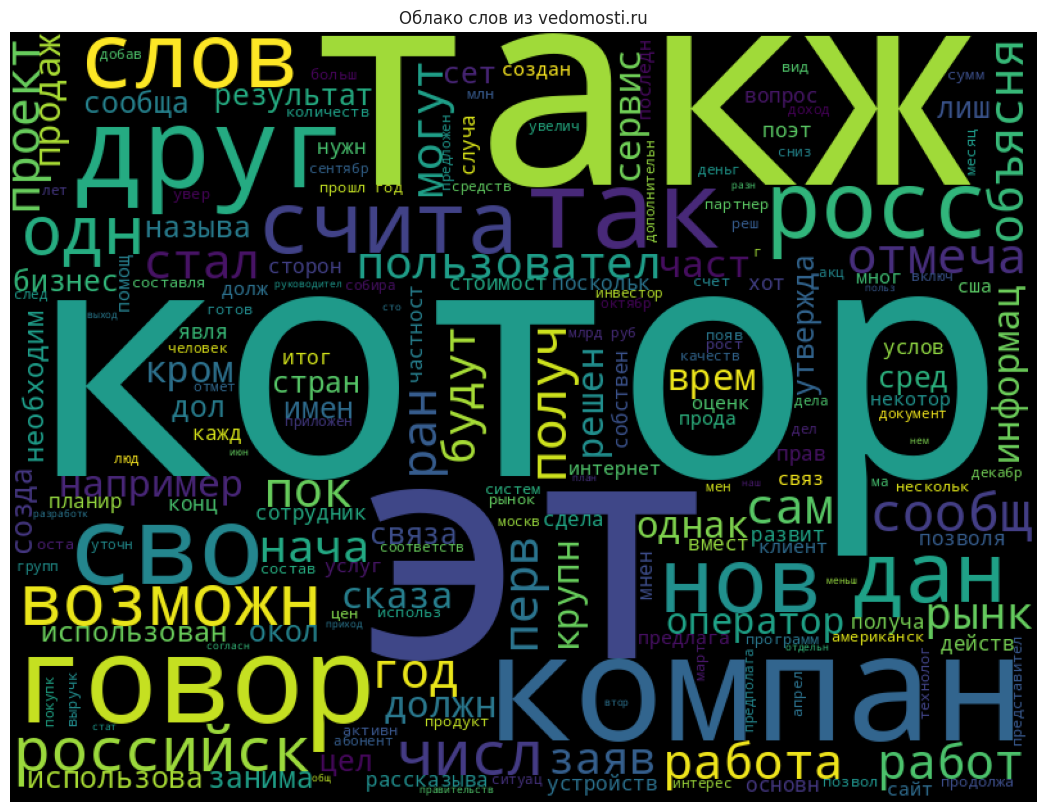

In [ ]:
plot_word_cloud(text_vedomosti, 'Облако слов из vedomosti.ru')

# Преобразование в TF-IDF-матрицу

**TF-IDF** *(от англ. TF — частота термина, IDF — обратная частота документа)* — статистическая мера, используемая для оценки важности слова в значении документа, являющегося частью коллекции документов или корпуса. 

Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции. 

Мера TF-IDF часто используется в задаче анализа текстов и информационного поиска, например, как один из критериев релевантности документа поисковому запросу, при расчете меры близости документов при кластеризации.

**TF** (term frequency — частота слова) — отношение числа вхождений некоторого слова к общему числу слов документа. Таким образом, оценивается важность слова 
$t_i$ в пределах отдельного документа.

$$
\textbf{tf}(t,d)=\frac{n_t}{\sum_kn_k}
$$
где $n_t$ есть число вхождений слова $t$ в документ, а в знаменателе — общее число слов в данном документе.

**IDF** (inverse document frequency — обратная частота документа) — инверсия частоты, с которой некоторое слово встречается в документах коллекции. Учёт IDF уменьшает вес широкоупотребительных слов. Для каждого уникального слова в пределах конкретной коллекции документов существует только одно значение IDF.

$$
\textbf{idf}(t,D)=\log{\frac{|D|}{|\{d_i\in D | t \in d_i\}|}}
$$

где:
- $|D|$ — число документов в коллекции;

- $|\{d_i\in D | t \in d_i\}|$ — число документов из коллекции $D$, в которых встречается $t$ (когда ${\displaystyle n_{t}\neq 0}$).

Выбор основания логарифма в формуле не имеет значения, поскольку изменение основания приводит к изменению веса каждого слова на постоянный множитель, что не влияет на соотношение весов.

Таким образом, мера TF-IDF является произведением двух сомножителей:

$$
\textbf{tf-idf}(t,d,D)=\text{tf}(t,d) \times \text{idf}(t,D)
$$

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

TfidfVectorizer тоже умеет делать предобработку: 

```
preprocessor=None, 
tokenizer=None, 
stop_words=None, 
token_pattern='(?u)\\b\\w\\w+\\b',  ...
```

Можно анализировать не только слова:
```
analyzer{‘word’, ‘char’, ‘char_wb’} or callable, default=’word’ 
```

```
max_features=None, 
vocabulary=None, 
binary=False, 
dtype=np.float64, 
norm='l2', 
use_idf=True, 
smooth_idf=True, 
sublinear_tf=False
```

Получим sparse (разреженную) матрицу, где строки по-прежнему документы, столбцы - токены (слова)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tf_idf = TfidfVectorizer(
    ngram_range=(1, 1),     # рассматриваем только отдельные слова; можно рассматривать слова и словосочетания (1,2) и т.д.
    max_df=0.8,             # ограничение на частоты слов: можно слова которые слишком часто встречаются в документах уменьшив max_df (это доля документов)
    min_df=10,              # ограничение на частоты слов: можно откинуть очень редкие слова увеличив min_df
    # max_features =        # можно задать максимальное количество рассматриваемых слов, иначе будут рассмотренны все
    # vocabulary =          # задать словарь вручную
)

# метод tf_idf преобразует массив документов в многомерный массив, состоящего из n кол-ва признаков
X = tf_idf.fit_transform(balanced_data['stemmed_news'])

In [ ]:
X.shape

(10162, 12668)

# Модели

Разобьём на тренировочную и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, balanced_data['source'], test_size=0.2)

## SVM

**Метод опорных векторов** (Support Vector Machines — SVM) — это набор контролируемых методов обучения, используемых для классификации, регрессии и обнаружения выбросов.

$$ \sum_{i \in SV}(\alpha_i — \alpha_i^*) K(x_i, x) + b $$

**Преимущества:**

- Эффективен в пространствах больших размеров.
По-прежнему эффективен в случаях, когда количество измерений превышает количество образцов.
- Использует подмножество обучающих точек в функции принятия решений (называемых опорными векторами), поэтому это также эффективно с точки зрения памяти.
- Универсальность: для функции принятия решения могут быть указаны различные функции ядра. Предоставляются общие ядра, но также можно указать собственные ядра.

**К недостаткам опорных векторных машин можно отнести:**

- Если количество функций намного превышает количество выборок, избегайте чрезмерной подгонки при выборе функций ядра, и термин регуляризации имеет решающее значение.
- SVM не предоставляют напрямую оценки вероятностей, они рассчитываются с использованием дорогостоящей пятикратной перекрестной проверки.

![](https://miro.medium.com/v2/resize:fit:921/1*06GSco3ItM3gwW2scY6Tmg.png)


In [ ]:
results = []
def write_result(model_name, y_test, y_pred):
  results.append([model_name, f"{accuracy_score(y_test, y_pred):.4f}"])

In [ ]:
svm = SVC(random_state = 42, probability=True)
svm.fit( X_train, y_train )

SVC(probability=True, random_state=42)

Проверим на тестовой выборке:

In [ ]:
y_test_pred = svm.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9728    0.9971    0.9848       681
         1.0     0.9733    0.9647    0.9690       680
         2.0     0.9667    0.9509    0.9587       672

    accuracy                         0.9710      2033
   macro avg     0.9709    0.9709    0.9708      2033
weighted avg     0.9709    0.9710    0.9709      2033



In [ ]:
write_result('SVM', y_test, y_test_pred)

## Дерево

**Дерево решений** (Decision Trees) — это один из алгоритмов машинного обучения, основанный на правиле: «Если <условие>, то <ожидаемый результат>».

![](https://loginom.ru/sites/default/files/blogpost-files/activation-function.svg)

Это непараметрический контролируемый метод обучения, используемый для классификации и регрессии. 

Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной, изучая простые правила принятия решений, выведенные из характеристик данных. Дерево можно рассматривать как кусочно-постоянное приближение.

Например, в приведенном ниже примере деревья решений учатся на основе данных аппроксимировать синусоиду набором правил принятия решений «если-то-иначе». Чем глубже дерево, тем сложнее правила принятия решений и тем точнее модель.

In [ ]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth = 10, random_state = 42)

dt.fit( X_train, y_train )

DecisionTreeClassifier(max_depth=10, random_state=42)

In [ ]:
y_test_pred = dt.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9290    0.9413    0.9351       681
         1.0     0.8703    0.9279    0.8982       680
         2.0     0.8835    0.8125    0.8465       672

    accuracy                         0.8942      2033
   macro avg     0.8943    0.8939    0.8933      2033
weighted avg     0.8943    0.8942    0.8935      2033



In [ ]:
write_result('Tree', y_test, y_test_pred)

## Бэггинг

При бэггинге используется следующий метод:

- Возьмите $b$ образцов с начальной загрузкой из исходного набора данных.

  - Напомним, что бутстрепная выборка — это выборка исходного набора данных, в которой наблюдения берутся с заменой.
- Постройте дерево решений для каждого загруженного образца.

- Усредните прогнозы каждого дерева, чтобы получить окончательную модель.

  - Для деревьев регрессии мы берем среднее значение прогноза, сделанного $B$-деревьями.

  - Для деревьев классификации мы берем наиболее часто встречающееся предсказание, сделанное $B$-деревьями.

  Он особенно полезен для деревьев решений, потому что они по своей природе имеют высокую дисперсию, а бэггинг может значительно уменьшить дисперсию, что приводит к меньшей ошибке теста.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging_m = BaggingClassifier( dt,
                               n_estimators = 15,
                               n_jobs = -1,
                              )

bagging_m.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                   random_state=42),
                  n_estimators=15, n_jobs=-1)

In [ ]:
y_test_pred = bagging_m.predict(X_test)
print(classification_report( y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9353    0.9545    0.9448       681
         1.0     0.8931    0.9338    0.9130       680
         2.0     0.9107    0.8497    0.8791       672

    accuracy                         0.9129      2033
   macro avg     0.9130    0.9127    0.9123      2033
weighted avg     0.9130    0.9129    0.9125      2033



In [ ]:
write_result('Bagging', y_test, y_test_pred)

## Случайный лес

**Случайный лес** — модель, состоящая из множества деревьев решений. 

Вместо того,чтобы просто усреднять прогнозы разных деревьев (такая концепция называется просто «лес»), эта модель использует две ключевые концепции, которые и делают этот лес случайным:
- Случайная выборка образцов из набора данных при построении деревьев.
- При разделении узлов выбираются случайные наборы параметров.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
 
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_test_pred = rf.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9376    0.9706    0.9538       681
         1.0     0.9256    0.9515    0.9384       680
         2.0     0.9285    0.8690    0.8978       672

    accuracy                         0.9306      2033
   macro avg     0.9306    0.9304    0.9300      2033
weighted avg     0.9306    0.9306    0.9301      2033



In [ ]:
write_result('Forest', y_test, y_test_pred)

## Бустинг

**Градиентный бустинг** – алгоритм машинного обучения для решения задач классификации и регрессии. 

Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются **деревья решений**. 

Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную. 

Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.

![](https://neurohive.io/wp-content/uploads/2018/11/predskazanija-gradientnogo-bustinga-496x570.png)

![](https://neurohive.io/wp-content/uploads/2018/11/vizualizacija-gradientnogo-bustinga-570x226.png)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=5,
                                random_state = 42)

gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

In [ ]:
y_test_pred = gb.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9712    0.9912    0.9811       681
         1.0     0.9357    0.9632    0.9493       680
         2.0     0.9592    0.9107    0.9344       672

    accuracy                         0.9552      2033
   macro avg     0.9554    0.9550    0.9549      2033
weighted avg     0.9554    0.9552    0.9550      2033



In [ ]:
write_result('Boosting', y_test, y_test_pred)

## Наивный байес

Наивные байесовские методы представляют собой набор алгоритмов обучения с учителем, основанных на применении теоремы Байеса с «наивным» предположением об условной независимости между каждой парой признаков при заданном значении переменной класса.

### Гаусс

Модель Гаусса предполагает, что все признаки попадают в нормальное распределение. Это означает, что если предикторы принимают непрерывные значения вместо дискретных, то модель предполагает, что эти значения взяты из распределения Гаусса.

$$
P(x_i | y) = \dfrac{1}{\sqrt{2 \pi \sigma^2_y}} \exp (- \dfrac{(x_i - \mu_y)^2}{2\sigma^2_y})
$$

Параметры $\sigma_y$ и $\mu_y$ оцениваются по методу максимального правдоподобия

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB, BernoulliNB

gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

y_test_pred = gnb.predict(X_test.toarray())

print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.6792    0.9266    0.7839       681
         1.0     0.9102    0.6412    0.7524       680
         2.0     0.8256    0.7679    0.7957       672

    accuracy                         0.7787      2033
   macro avg     0.8050    0.7785    0.7773      2033
weighted avg     0.8049    0.7787    0.7772      2033



In [ ]:
write_result('Naive Gauss', y_test, y_test_pred)

### Бернулли

Классификатор Бернулли работает аналогично полиномиальному классификатору, но переменные-предикторы являются независимыми булевыми переменными. Например, если конкретное слово присутствует или нет в документе. Эта модель также известна задачами классификации документов. Правило в теореме Бернулиса будет

$$
P(x_i | y) = P(i | y)x_i + (1 - P(i | y))(1 - x_i)
$$

In [ ]:
bnb = BernoulliNB()

bnb.fit(X_train.toarray(), y_train)
y_test_pred = bnb.predict(X_test.toarray())

print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9488    0.9515    0.9501       681
         1.0     0.8412    0.9426    0.8890       680
         2.0     0.8895    0.7783    0.8302       672

    accuracy                         0.8913      2033
   macro avg     0.8931    0.8908    0.8898      2033
weighted avg     0.8932    0.8913    0.8900      2033



In [ ]:
write_result('Naive Bernoulli', y_test, y_test_pred)

## Голосование

In [ ]:
from sklearn.ensemble import VotingClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier
# см. также Voting Regressor

models = [('SVM', svm ),        
          ('Tree', dt ),
          ('Bagging', bagging_m ),
          ('Bernoulli', bnb ),
          ('Boosting', gb )]   

voting_m = VotingClassifier( estimators=models, voting='soft')

voting_m.fit(X_train, y_train)

VotingClassifier(estimators=[('SVM', SVC(probability=True, random_state=42)),
                             ('Tree',
                              DecisionTreeClassifier(max_depth=10,
                                                     random_state=42)),
                             ('Bagging',
                              BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                                                 random_state=42),
                                                n_estimators=15, n_jobs=-1)),
                             ('Bernoulli', BernoulliNB()),
                             ('Boosting',
                              GradientBoostingClassifier(max_depth=5,
                                                         random_state=42))],
                 voting='soft')

In [ ]:
y_test_pred = voting_m.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9753    0.9868    0.9810       681
         1.0     0.9332    0.9662    0.9494       680
         2.0     0.9594    0.9137    0.9360       672

    accuracy                         0.9557      2033
   macro avg     0.9560    0.9556    0.9555      2033
weighted avg     0.9560    0.9557    0.9556      2033



In [ ]:
write_result('Voting', y_test, y_test_pred)

# Заключение

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy'], data=results)
results_df.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy
0,SVM,0.9710
7,Voting,0.9557
4,Boosting,0.9552
3,Forest,0.9306
2,Bagging,0.9129
1,Tree,0.8942
6,Naive Bernoulli,0.8913
5,Naive Gauss,0.7787


## Первый результат

Самый лучший accuracy показал **метод опорных векторов (0.9602)**

Также с отличным результатом: **градиентный бустинг (0.9552), голосование (0.9508) и случайный лес (0.9370)**

Остальные алгоритмы показали тоже довольно неплохой результат:
- Бэггинг (0.9075)
- Дерево (0.8938)
- Наивный Байес Бернулли (0.8938)

Самый низкий результат показал **наивный байес Гаусса (0.7634)**

Результаты в общем и целом хорошие, но по карте слов видно, что есть много слов "который", "также", "как", "так" и т.д. Хорошо бы их удалить и посмотреть на результат.

## UPD 1

После дополнительной обработки текстов результаты получились неоднозначны.

Более того время обучения увеличилось в несколько раз методами опорных векторов (11 минут) и голосованием (16 минут).

Бустинг завершился за 4 минуты.

Стало лучше:
- Accuracy метода опорных векторов выросло до 0.9631
- Наинвый байес Гаусса вырос до 0.7718

Стало хуже:
- Бустинг показал результат хуже, упал до 0.9503
- Голосование тоже ухудшилось до 0.9474
- Случайный лес упал до 0.9267
- Бэггинг 0.9011
- Наивный байес Бернулли 0.8839
- Дерево 0.8795

## UPD 2

Уберём дополнительную предобработку и попробуем не удалять числа из текстов.

Обучение метода голосование заняло аж 18 минут!

Стало лучше:
- Ничего...

Стало хуже (но лучше, чем с доп. предобработкой):
- Метод опорных векторов 0.9597
- Бустинг 0.9528
- Бэггинг 0.9036
- Дерево 0.8888

Стало хуже обоих случаев:
- Голосование 0.9474
- Случайный лес 0.9213
- Наивный байес Бернулли 0.8810
- Наивный байес Гаусса 0.7541

## UPD 3

Вернул всё к прежнему виду! Единственное изменил это количество слов в тексте раньше считалось по исходному тексту, а сейчас по обработанному.

Результаты стали лучше относительно других методов:
- Метод опорных векторов 0.9710
- Голосование 0.9557
-	Бустинг 0.9552 (такой же как в первый раз)
-	Бэггинг 0.9129
-	Дерево 0.8942
-	Наиный байес Гаусса 0.7787

Хуже, чем в первом случае, но лучше других:
-	Случайный лес 0.9306 (в первом 0.9370)
-	Наиный байес Бернулли 0.8913 (в первом 0.8938)